**Machine learning pipeline for my Bolt travel dataset**

 **Machine Learning System Overview**
 
- **Objective**: Predict ride fare, trip duration, or demand trends based on historical Uber trip data.
- **Approach**: Supervised learning (if predicting fare/time) or time-series modeling (if predicting demand).

**ML Pipeline**:
1. Data Cleaning
2. Data Transformation (Feature Engineering)
3. Exploratory Data Analysis (EDA)
4. Model Selection & Training
5. Prediction & Evaluation

In [3]:
# import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


 **Data Cleaning**:
- Handle missing values
- Remove duplicate entries
- Convert date-time fields to proper format
- Filter out anomalies (e.g., negative trip durations or unrealistic fares)


In [4]:
# creates the path file for the csv file
file_path = 'data/Data.csv'

df = pd.read_csv(file_path)
df.head()

,period_name,period_start,period_end,email,phone,first_name,last_name,country_name,city_name,from,...,ride_price,total_price,vat,currency,distance,user_invoice_link,driver_official_name,driver_vat_code,invoice_from_name,invoice_from_vat_code
0,business_monthly,2025-02-01T00:00:00.000Z,2025-02-28T23:59:59.000Z,simanga.photojournalist@gmail.com,27739363211,Simanga,Mchunu,South Africa,Johannesburg,"24 Blackberry Street, Zwartkop, Tshwane",...,119,119,NaN,zar,21171,https://doclink.live.boltsvc.net/invoice/pdf?i...,Mantsha Ramaite,NaN,NaN,NaN
1,business_monthly,2025-02-01T00:00:00.000Z,2025-02-28T23:59:59.000Z,simanga.photojournalist@gmail.com,27739363211,Simanga,Mchunu,South Africa,Johannesburg,Sportsmans Warehouse West Rand Retail Crossing...,...,332,332,NaN,zar,51641,https://doclink.live.boltsvc.net/invoice/pdf?i...,Thulani Radebe,NaN,NaN,NaN
2,business_monthly,2025-02-01T00:00:00.000Z,2025-02-28T23:59:59.000Z,simanga.photojournalist@gmail.com,27739363211,Simanga,Mchunu,South Africa,Johannesburg,"Old Mint Office Park, Old Johannesburg Road, L...",...,165,165,NaN,zar,27320,https://doclink.live.boltsvc.net/invoice/pdf?i...,David Sello Rakgalakane,NaN,NaN,NaN
3,business_monthly,2025-02-01T00:00:00.000Z,2025-02-28T23:59:59.000Z,simanga.photojournalist@gmail.com,27739363211,Simanga,Mchunu,South Africa,Johannesburg,"394 Swanepoel Street, Erasmia, Tshwane",...,289,289,NaN,zar,55721,https://doclink.live.boltsvc.net/invoice/pdf?i...,Ahmed Mohamed Sha,NaN,NaN,NaN
4,business_monthly,2025-02-01T00:00:00.000Z,2025-02-28T23:59:59.000Z,simanga.photojournalist@gmail.com,27739363211,Simanga,Mchunu,South Africa,Johannesburg,"CALTEX DAWSON MOTORS, Main Road, Erasmia, Cent...",...,140,140,NaN,zar,25699,https://doclink.live.boltsvc.net/invoice/pdf?i...,Brutus Motobetjane,NaN,NaN,NaN


In [5]:
# Convert date column to datetime format
df["period_start"] = pd.to_datetime(df["period_start"]) 
df["period_end"] = pd.to_datetime(df["period_end"])

# drop the irrelevant columnd and sensitive 
column_to_drop = ["email", "phone", "first_name", "last_name","invoice_from_name",
 "driver_official_name", "driver_vat_code", "invoice_from_vat_code", "vat"]


df_cleaned = df.drop(columns=column_to_drop)

# Check for duplicate and remove them
df_cleaned = df_cleaned.drop_duplicates()

# Check for missing values
missing_values = df_cleaned.isnull().sum()

# Show the cleaned data frame
df_cleaned.info(), missing_values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   period_name        11 non-null     object             
 1   period_start       11 non-null     datetime64[ns, UTC]
 2   period_end         11 non-null     datetime64[ns, UTC]
 3   country_name       11 non-null     object             
 4   city_name          11 non-null     object             
 5   from               11 non-null     object             
 6   to                 11 non-null     object             
 7   search_category    11 non-null     object             
 8   ride_start         11 non-null     object             
 9   ride_end           11 non-null     object             
 10  ride_price         11 non-null     int64              
 11  total_price        11 non-null     int64              
 12  currency           11 non-null     object           

(None,
 period_name          0
 period_start         0
 period_end           0
 country_name         0
 city_name            0
 from                 0
 to                   0
 search_category      0
 ride_start           0
 ride_end             0
 ride_price           0
 total_price          0
 currency             0
 distance             0
 user_invoice_link    0
 dtype: int64)

 **Data Transformation**
- Feature Engineering:
- Extract hour, day, and month from timestamps
- Calculate trip distance (if coordinates are available)
- Categorize pickup/dropoff locations
- Encode categorical variables (e.g., payment type, city zones)
- Normalize/scale numeric features (e.g., distance, fare)

In [6]:
# Convert ride_start and ride_end to datetime format
df_cleaned["ride_start"] = pd.to_datetime(df_cleaned["ride_start"])
df_cleaned["ride_end"] = pd.to_datetime(df_cleaned["ride_end"])

# create a new feature: ride duration in minutes
df_cleaned["ride_duration"] = (df_cleaned["ride_end"] - df_cleaned["ride_start"]).dt.total_seconds() / 60

# Extract te date components from ride_start
df_cleaned["ride_day_of_week"] = df_cleaned["ride_start"].dt.dayofweek # Monday = 0, Sunday = 6
df_cleaned["ride_hour"] = df_cleaned["ride_start"].dt.hour 

# Normalize distance and ride price
df_cleaned["distance_km"] = df_cleaned["distance"] / 1000 # Convert meters to km 
df_cleaned["ride_price_norm"] = (df_cleaned["ride_price"] -df_cleaned["ride_price"].min()) / \
    (df_cleaned["ride_price"].max() - df_cleaned["ride_price"].min())

# Drop the old distance column
df_transformed = df_cleaned.drop(columns=["distance"])

# Show the transformed dataset
df_transformed.head()

,period_name,period_start,period_end,country_name,city_name,from,to,search_category,ride_start,ride_end,ride_price,total_price,currency,user_invoice_link,ride_duration,ride_day_of_week,ride_hour,distance_km,ride_price_norm
0,business_monthly,2025-02-01 00:00:00+00:00,2025-02-28 23:59:59+00:00,South Africa,Johannesburg,"24 Blackberry Street, Zwartkop, Tshwane","600 Bengal Street, Laudium Ext 3, Tshwane",Go Hatch,2025-02-17 17:27:56+00:00,2025-02-17 17:55:02+00:00,119,119,zar,https://doclink.live.boltsvc.net/invoice/pdf?i...,27.100000,0,17,21.171,0.280405
1,business_monthly,2025-02-01 00:00:00+00:00,2025-02-28 23:59:59+00:00,South Africa,Johannesburg,Sportsmans Warehouse West Rand Retail Crossing...,"394 Swanepoel Street, Erasmia, Tshwane",Bolt,2025-02-17 14:21:51+00:00,2025-02-17 15:17:12+00:00,332,332,zar,https://doclink.live.boltsvc.net/invoice/pdf?i...,55.350000,0,14,51.641,1.000000
2,business_monthly,2025-02-01 00:00:00+00:00,2025-02-28 23:59:59+00:00,South Africa,Johannesburg,"Old Mint Office Park, Old Johannesburg Road, L...","600 Bengal Street, Laudium Ext 3, Tshwane",Go Hatch,2025-02-19 16:17:25+00:00,2025-02-19 16:49:59+00:00,165,165,zar,https://doclink.live.boltsvc.net/invoice/pdf?i...,32.566667,2,16,27.320,0.435811
3,business_monthly,2025-02-01 00:00:00+00:00,2025-02-28 23:59:59+00:00,South Africa,Johannesburg,"394 Swanepoel Street, Erasmia, Tshwane","Outdoor Warehouse Strubensvalley, Retail Cross...",Go Sedan,2025-02-19 06:33:24+00:00,2025-02-19 07:53:53+00:00,289,289,zar,https://doclink.live.boltsvc.net/invoice/pdf?i...,80.483333,2,6,55.721,0.854730
4,business_monthly,2025-02-01 00:00:00+00:00,2025-02-28 23:59:59+00:00,South Africa,Johannesburg,"CALTEX DAWSON MOTORS, Main Road, Erasmia, Cent...",Prime Cleaning Suppliers Johannesburg (Pty) Lt...,Go Hatch,2025-02-20 05:41:33+00:00,2025-02-20 06:12:37+00:00,140,140,zar,https://doclink.live.boltsvc.net/invoice/pdf?i...,31.066667,3,5,25.699,0.351351


**Exploratory Data Analysis (EDA)**
- Visualize ride trends over time
- Distribution of fares and trip distances
- Relationship between ride duration, distance, and fare
- Identify outliers (e.g., abnormally high fares)

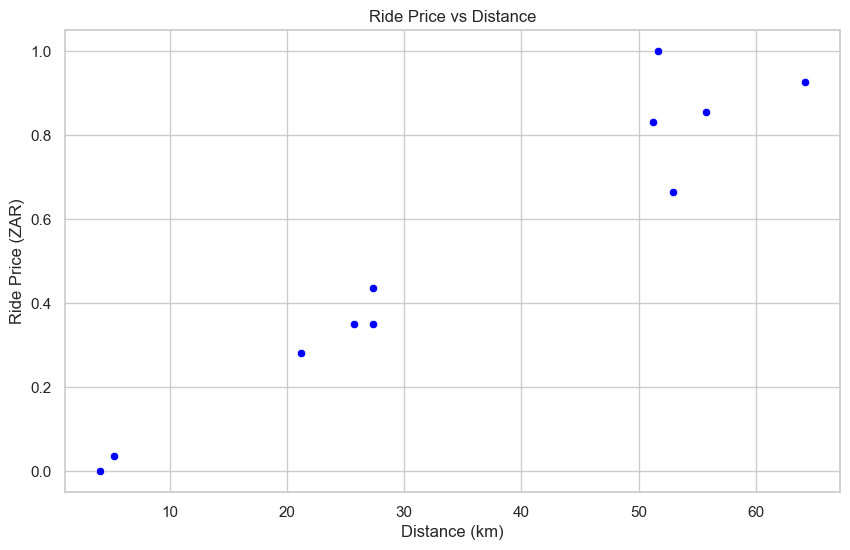

C:\Users\User\AppData\Local\Temp\ipykernel_792\122764407.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df_transformed["ride_hour"], palette= "coolwarm")


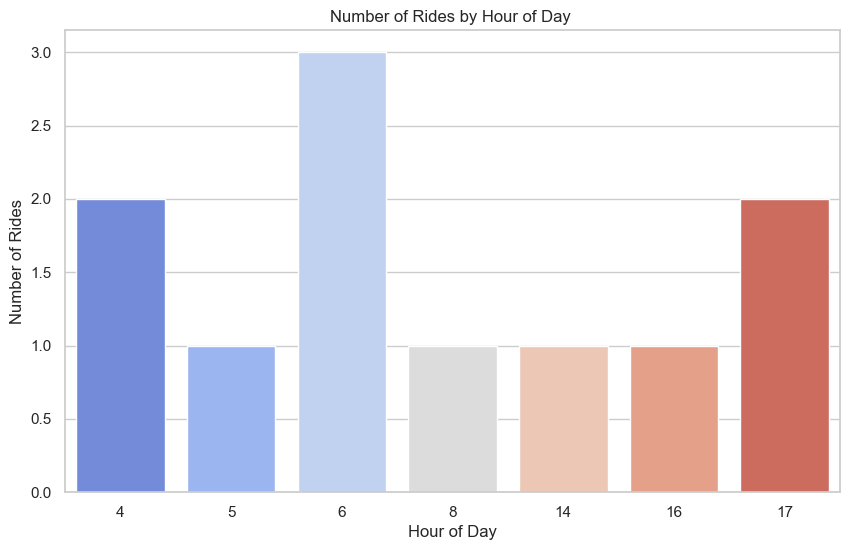

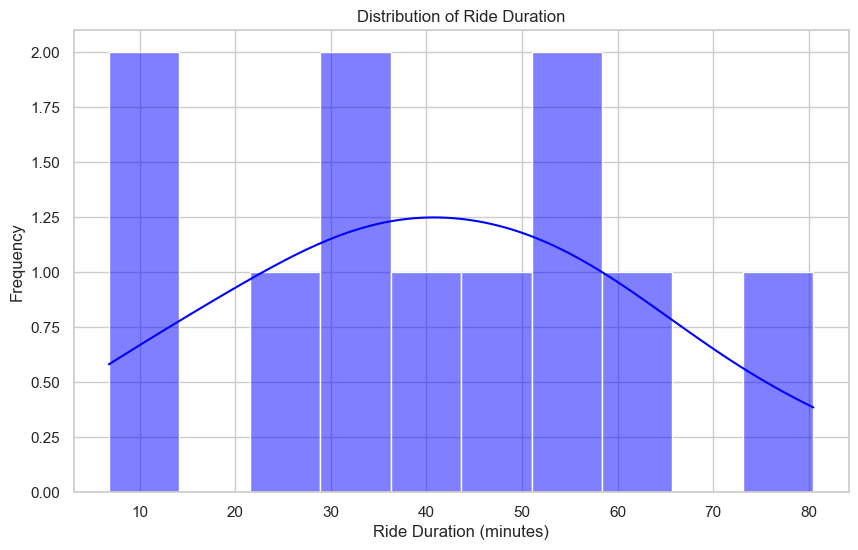

In [7]:
# Set the visualisation style
sns.set_theme(style = "whitegrid")

# Plot ride vs distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_transformed["distance_km"], y = df_transformed["ride_price_norm"], color = "blue")
plt.title("Ride Price vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Ride Price (ZAR)")
plt.show()

# Plot ride Count per hour
plt.figure(figsize=(10, 6))
sns.countplot(x = df_transformed["ride_hour"], palette= "coolwarm")
plt.title("Number of Rides by Hour of Day ")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.show()

# Plot: Ride Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_transformed["ride_duration"], bins= 10, kde=True, color = "blue")
plt.title("Distribution of Ride Duration")
plt.xlabel("Ride Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

# Plot 



**Interpreting the Trend**
- If Prices Show an Upward Trend:

This may indicate higher demand or dynamic pricing effects over time.
Regular riders might experience increased costs.
- If Prices Fluctuate or Drop After a Break:

Some ride-hailing apps adjust pricing based on user inactivity.
Possible discounts or incentives may reduce fare after a break.

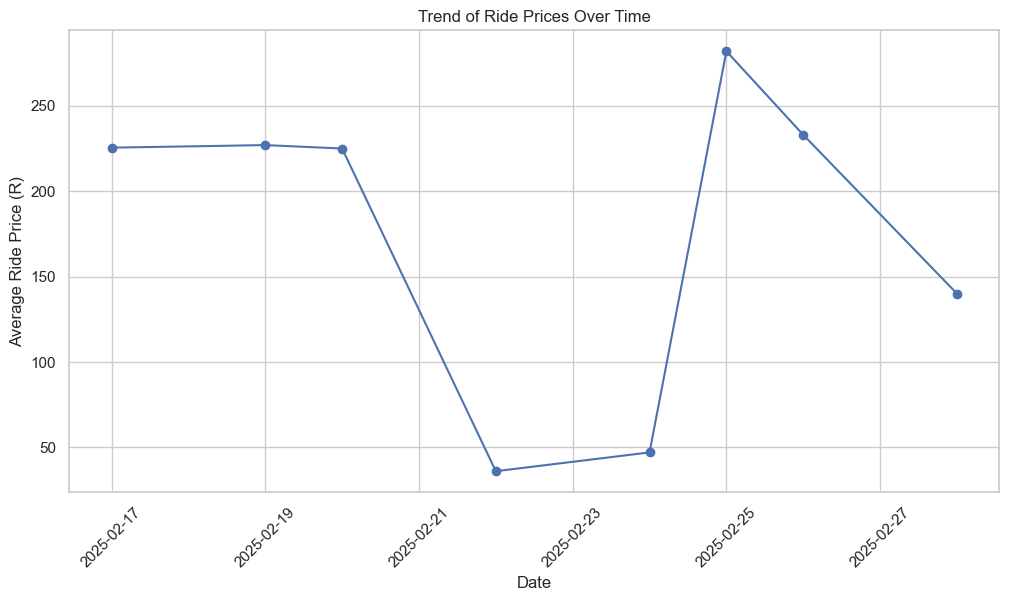

In [8]:
# Convert ride_start to datetime
df["ride_start"] = pd.to_datetime(df["ride_start"], errors='coerce')

# Extract date and calculate daily average fare
df["ride_date"] = df["ride_start"].dt.date
daily_avg_fare = df.groupby("ride_date")["ride_price"].mean().reset_index()

# Plot Trend Line Chart
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_fare["ride_date"], daily_avg_fare["ride_price"], marker='o', linestyle='-')

plt.xlabel("Date")
plt.ylabel("Average Ride Price (R)")
plt.title("Trend of Ride Prices Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Model Selection & Training**
- If predicting ride fare or duration:
- Regression models (Linear Regression, Random Forest, XGBoost)
- If predicting demand trends:
- Time-series forecasting models (ARIMA, LSTM)
- If classifying ride types:
- Logistic Regression, Decision Trees, or Neural Networks

In [9]:
# Identify categorical columns and encode them
categorical_cols = df_transformed.select_dtypes(include=['object']).columns.tolist()
df_transformed = pd.get_dummies(df_transformed, columns=categorical_cols, drop_first=True)

# Drop unnecessary columns
df_transformed = df_transformed.drop(columns=["ride_start", "ride_end"], errors='ignore')

# Ensure only numeric columns remain
df_transformed = df_transformed.select_dtypes(include=['number'])

# Define features and target variable
X = df_transformed.drop(columns=["ride_price"], errors='ignore')
y = df_transformed["ride_price"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

best_model = None
best_score = float("-inf")

# Train models and evaluate performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    print(f"{name} - MAE: {mean_absolute_error(y_test, y_pred):.2f}, R²: {score:.2f}")

    if score > best_score:
        best_score = score
        best_model = model  # Ensure the best model is stored
"""
# Hyperparameter tuning using GridSearchCV (for Random Forest as example)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_rf_model = grid_search.best_estimator_
    print(f"Best Random Forest Model: {best_rf_model}")
"""
    

# Save the best model
joblib.dump(best_model, "model_uber.pkl")  
print(f"Best model: {best_model}")

Linear Regression - MAE: 0.12, R²: 1.00
Random Forest - MAE: 42.03, R²: 0.67
XGBoost - MAE: 53.67, R²: 0.45
Best model: LinearRegression()
